## Extra Note for this Notebook

This Python Notebook modified from the general Civic Tech DC Ballot Initiative [notebook](https://github.com/Civic-Tech-Ballot-Inititiave/Ballot-Initiative/blob/main/notebooks/onboarding_notebook.ipynb), and configured for running on Google Colab, with no need to create local virtual environments, installing dependencies, etc.

One thing to keep in mind is that Google Colab does not allow permanent file storage, and will delete uploaded files after a certain amount of idle time has passed. For a more permanent solution, saving the files to google drive, or some other file hosting solutions is recommended.

Files can also be uploaded directly through the UI instead of through code, which seems to be much faster.


## What you need to be able to run this notebook (and the application)

- **Open AI API key:** Key allows you to query various GPT models, in particular the image model that we use to perform the optical character recognition
    - Go here to sign up for Open AI account and get an API key https://platform.openai.com/docs/quickstart
    - When you get your API key, create a file called `.env` in the home directory of this repository (i.e., not within the directory of this notebook but the one that contains the notebook directory) and add the line `OPENAI_API_KEY = <YOUR API KEY>` anywhere inside.
- **2023 Voter Registration CSV file:** CSV file of past registered voter records; This file was requested from the DC BOE and currently lives in a google drive.
    - Send a message to Mobolaji Williams (or most frequent recent poster) in Slack for access: https://app.slack.com/client/T02GC3VEL/C04U3D9AWER
    - The file should be named `raw_feb_23_city_wide.csv` and put it in the folder in the home directory of this repository.
- **Sample Ballot Initiative Page:** Scanned jpg of a ballot initiative page. Exists in the same google drive that the 2023 Voter Records lives within
    - Send a message in Slack (or most frequent recent poster) for access: https://app.slack.com/client/T02GC3VEL/C04U3D9AWER
    - The file should be named `page-0.jpg` should be put in the home directory of this repository.
- **Python Libraries:** Uncomment and execute the cell below to install all the requirements needed for the application and notebook.








In [ ]:
## installing requirements
!pip install "openai==1.36.0"
!pip install "rapidfuzz==3.9.3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.7/328.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.2 MB/s eta 0:00:00


In [ ]:
# needed libraries
import base64
import pprint
import os
import json
import time
from rapidfuzz import fuzz
from openai import OpenAI
import pandas as pd
from google.colab import userdata, files


In [ ]:
try:
  if userdata.get('OPENAI_API_KEY'):
    print("The OPENAI API key already exists")
except:
  print("Please click on the secrets icon (a key) on the left hand menu and click on 'Add New Secret.' Use OPENAI_API_KEY as the name, the OpenAI key as your key. Keep running this block until this message is gone.")

The OPENAI API key already exists


In [ ]:
#set OPENAI_API_KEY secret as variable OPEN_API_KEY

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

----------------------

# Onboarding Noteboook

**(July 18, 2024)**

Woot! Thanks for your interest in the Ballot Initiative Project! This notebook was created to walk you through the main parts of the project (as they exist according to the above date), and thus give you a good background on how to contribute to the fundamental tech stack. Currently the application is quite simple, but we are working each month to improve functionality and usability and YOU can be a part of these improvements!

## The Ballot Initiative Problem

Let' say you wanted to get a minimum wage increase on the ballot in DC. By get "on the ballot," we mean put the "Should Minimum Wage be raised to $15?" question on a ballot in the next election. That way voters could vote on the issue and it could be changed city wide.

How would you get such an issue on the ballot? According to the the City Council of DC (https://code.dccouncil.gov/us/dc/council/code/sections/1-1001.16), after getting your initiative approved by the council, you would then need to collect signatures from the registered voters in the district. If you get enough *validated* signatures, then your issue gets on the ballot and people can vote on it. But How many validated signatures do you need?  Here is a direct quote from the website:

> In order for any initiative measure or referendum measure to qualify for the ballot for consideration by the electors of the District, the proposer of the initiative measure or referendum measure shall secure the valid signatures of registered qualified electors upon the initiative or referendum measure equal in number to **5% of the registered qualified electors in the District; provided, that the total signatures submitted include 5% of the registered qualified electors in each of 5 or more of the 8 wards**.

So you would need to get 5% of the total population of registered voters and 5% per ward (for at least 5 wards) for registered voters. How could you ensure you meet this threshold? Mostly through ballpark estimates. You get a bunch of volunteers to go out into the city and collect signatures, and then at the end of the day you tally how many you collected. You keep a running tally per ward, and you check the results against a voter database, so that when you finally submit the list to the DC BOE you have a good sense of how many signatures are valid.

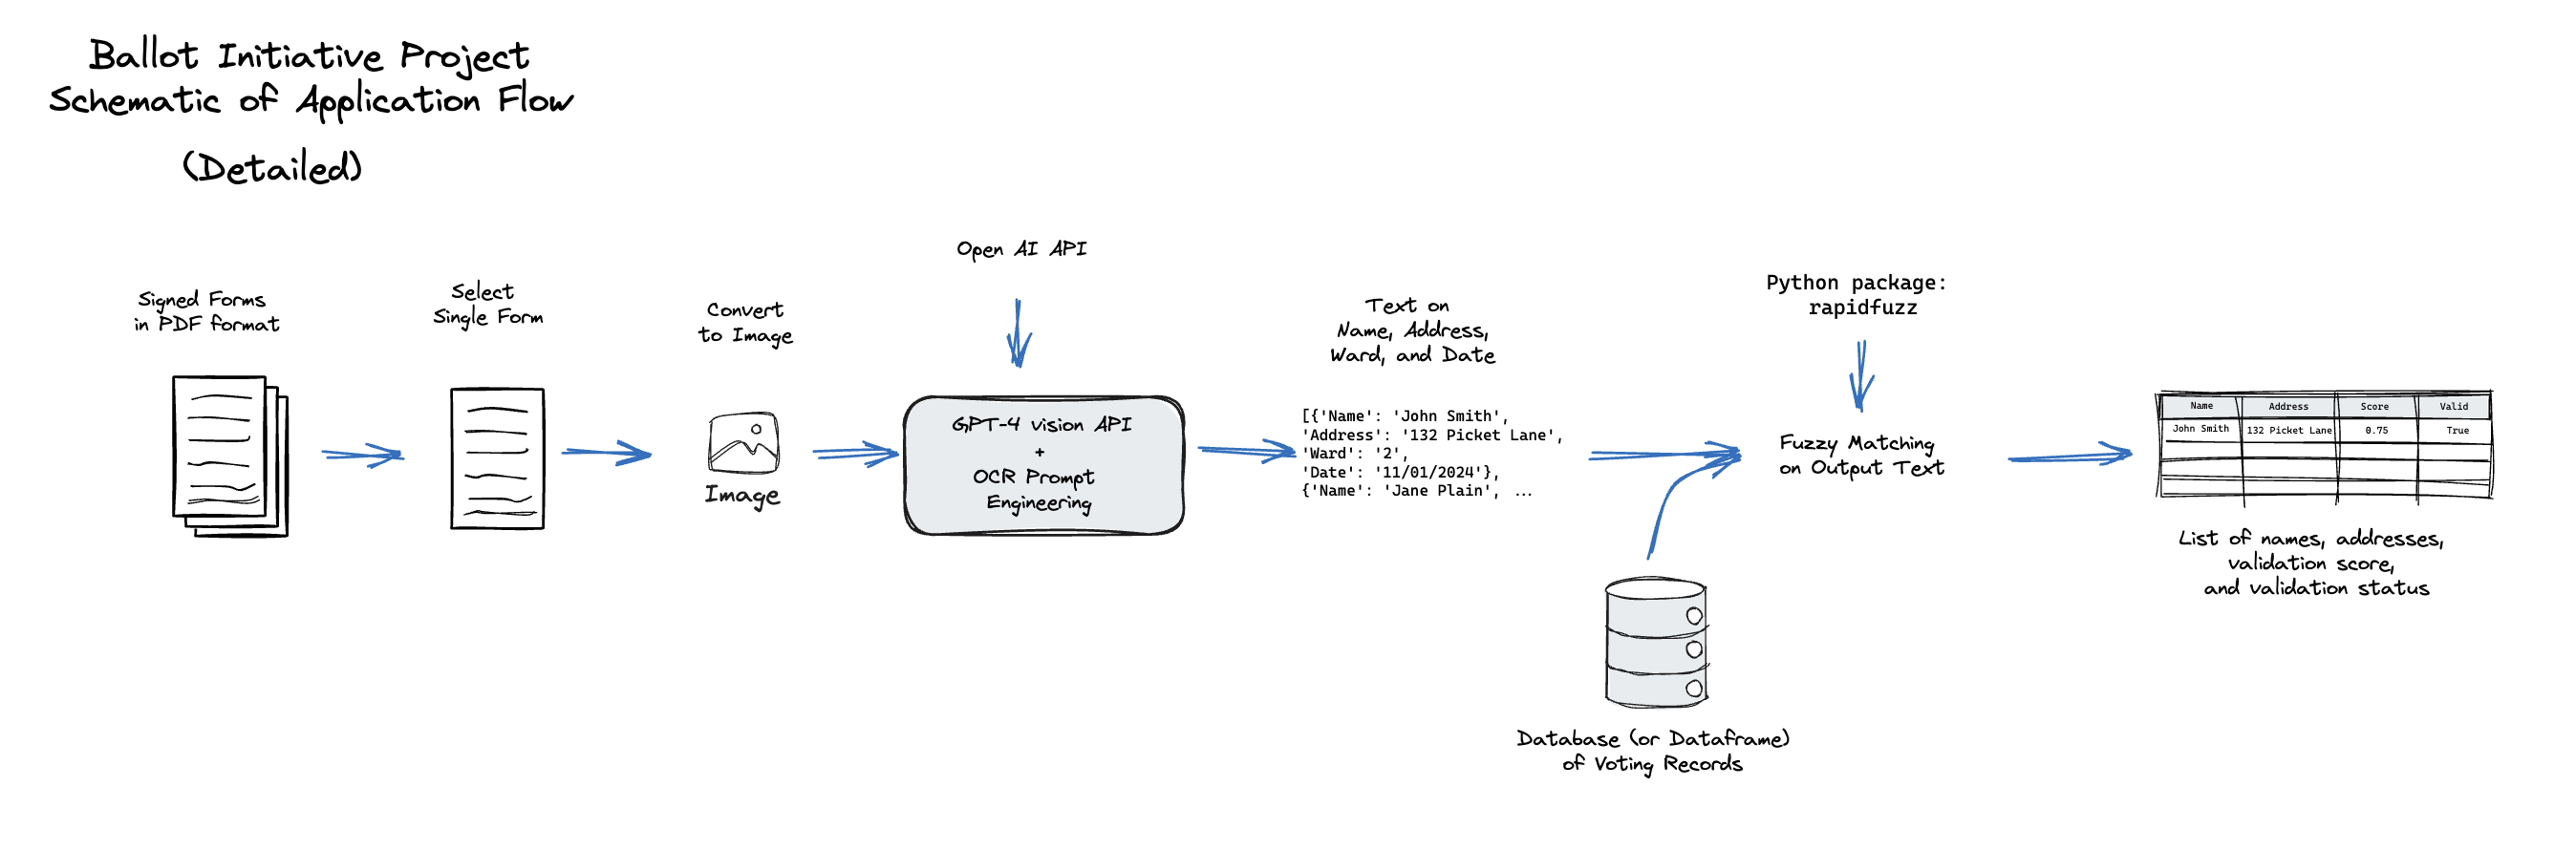

The general data flow of the project is shown above. PDFs of ballots come in and a validated list of those who signed the ballot comes out. This flow can be broken into two parts an OCR (i.e., Optical Character Recognition) part and a Validation/Match part. Here are

**OCR Processing of Signatures**
- A collection of signed ballots in PDF format come in. We select a single page of that PDF. We convert that page into an image (importantly one that can be ingested by GPT). We use GPT's vision capabilities to perform Optical Character Recognition on the image, and extract the names and addresses of those who signed the ballot.

**Validation/Matching of Extracted Signatures**
- From the collection of names and addresses, we compare the elements of the list with a record of voters. We want to determine whether the voter name and address extracted from the ballot matches one found in the Voter Record. If their is a match, then that voter record is said to be validated.

Below we breakdown what pieces of this process currently exist and we end by outlining some ways to contribute to the existing project.

## OCR Processing of Signatures

#### Basic GPT Image Recognition

For our OCR, we are using the Open AI Vision API (described here: https://platform.openai.com/docs/guides/vision) to extract signatures from a PDF page of the ballot. To get familiar with using it we can consider a simpler example than a ballot and ask GPT to explain the Ballot Initiative diagram at the start of this notebook.

The first thing we need to do is put the image in a format that the API can recognize. Below is a function (complete with the stackoverflow page it was stolen from) that properly converts the image.

In [ ]:
# Function is needed to put image in proper format for uploading
# From: https://stackoverflow.com/questions/77284901/upload-an-image-to-chat-gpt-using-the-api
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

Next, we apply the function to the `ballot_inititiave_flow.png` file that exists at the start of this notebook.

Browse to find the ballot initiative flow file locally:

In [ ]:
uploaded = files.upload()

for file_name, file_content in uploaded.items():
  with open(file_name, 'wb') as new_file:
    new_file.write(file_content)
  print(f'User uploaded file "{file_name}"')

Saving ballot_initiative_flow.png to ballot_initiative_flow.png
User uploaded file "ballot_initiative_flow.png"


In [ ]:
# Path to your image
image_path = file_name

# Getting the base64 string
base64_image = encode_image(image_path)

Finally we ask the API to explain the image.

In [ ]:
# sample use of open AI API

prompt = "Please explain the meaning of the provided diagram."

client = OpenAI(api_key = OPENAI_API_KEY)

messages = [{"role": "user",
             "content": [{"type": "text",
                          "text": prompt},
                          {"type": "image_url",
                           "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
                           }
                        ]
              }
              ]

results = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    temperature=0.0,
)

print(results.choices[0].message.content)

The provided diagram illustrates the detailed application flow for a Ballot Initiative Project. Here is a step-by-step explanation of the process:

1. **Signed Forms in PDF Format**:
   - The process begins with a collection of signed forms in PDF format.

2. **Select Single Form**:
   - A single form is selected from the collection of PDFs.

3. **Convert to Image**:
   - The selected PDF form is converted into an image format.

4. **GPT-4 Vision API + OCR Prompt Engineering**:
   - The image is processed using the GPT-4 Vision API along with OCR (Optical Character Recognition) prompt engineering. This step involves using the OpenAI API to extract text from the image.
   - The extracted text includes details such as Name, Address, Ward, and Date.

5. **Text on Name, Address, Ward, and Date**:
   - The extracted text is structured in a format like:
     ```
     [{'Name': 'John Smith', 'Address': '132 Picket Lane', 'Ward': '2', 'Date': '11/01/2024'},
      {'Name': 'Jane Plain', ...}]
 

#### Extract Signature Function

Following the simple example above, we can now pursue the desired use case: Extracting signatures from a jpg version of a ballot. We currently have a prompt to do this, but we have to tell the API that these signatures are "toy examples," in order for it to properly process the personal data. So this is not an ideal approach to OCR. Finding better OCR approaches is one of the tasks that can be worked on for this project.

In [ ]:
def extract_signature_info(image_path):

    """
    Extracts names and addresses from single ballot image.
    """

    # Getting the base64 string
    base64_image = encode_image(image_path)

    # open AI client definition
    client = OpenAI(api_key= OPENAI_API_KEY)

    # prompt message
    messages = [
          {
            "role": "user",
            "content": [
              {
                "type": "text",
                "text": """Using the written text in the image create a list of dictionaries where each dictionary consists of keys 'Name', 'Address', 'Date', and 'Ward'. Fill in the values of each dictionary with the correct entries for each key. Write all the values of the dictionary in full. Only output the list of dictionaries. No other intro text is necessary. The output should be in JSON format, and look like
                {'data': [{"Name": "John Doe",
                          "Address": "123 Picket Lane",
                          "Date": "11/23/2024",
                          "Ward": "2"},
                          {"Name": "Jane Plane",
                          "Address": "456 Fence Field",
                          "Date": "11/23/2024",
                          "Ward": "3"},
                          ]} """
              },
              {
                "type": "image_url",
                "image_url": {
                  "url": f"data:image/jpeg;base64,{base64_image}"
                }
              }
            ]
          }
        ]

    # processing result through GPT
    results = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.0,
        response_format={"type": "json_object"}
    )

    # convert json into list
    signator_list = json.loads(results.choices[0].message.content)['data']

    return signator_list

Testing function on single ballot

Browse to find the ballot form locally:

In [ ]:
#Upload ballot files

uploaded = files.upload()

for ballot_file_name, file_content in uploaded.items():
  with open(ballot_file_name, 'wb') as new_file:
    new_file.write(file_content)
  print(f'User uploaded file "{ballot_file_name}"')

Saving page-0.jpg to page-0.jpg
User uploaded file "page-0.jpg"


In [ ]:
# timing the result
start_time = time.time()

# ocr extraction of the text
resulting_data = extract_signature_info(ballot_file_name)

# pretty printing the data
pprint.pprint(resulting_data)

# recording elapsed time
print(f'\nElapsed Time: {time.time()-start_time:.3f} secs')

[{'Address': '1501 Harry Thomas Way NE Apt 6A',
  'Date': '1/8/22',
  'Name': 'James Hatch',
  'Ward': '5'},
 {'Address': '1112 7th St NW Apt 703',
  'Date': '1/8/22',
  'Name': 'Lynn Ly',
  'Ward': '2'},
 {'Address': '1514 4th St SW Apt 518',
  'Date': '1/8/22',
  'Name': 'Bruce Mumia',
  'Ward': '6'},
 {'Address': '22 M St NE Apt 611',
  'Date': '1/8/22',
  'Name': 'Molling Liu',
  'Ward': '6'},
 {'Address': '1300 K St SE Apt 302',
  'Date': '1/8/22',
  'Name': 'Alexandra Karabatsos',
  'Ward': '6'}]

Elapsed Time: 9.996 secs


## Validation/Matching of Extracted Signatures

The second part of the pipeline is the validation/matching of the extracted signatures through "fuzzy matching" (https://en.wikipedia.org/wiki/Approximate_string_matching) between the OCR output of the ballot pages and a voter records file. Why is this necessary? Here is a direct quote from the council of DC page.

> For the purpose of verifying a signature on any petition filed pursuant to this section, **the Board shall first determine that the address on the petition is the same as the residence shown on the signer’s voter registration record. If the address is different, the signature shall not be counted as valid unless the Board’s records show that the person was registered to vote from the address listed on the petition at the time the person signed the petition.**

So for each signature in an initiative, we need to extract the name of the signor and their address and we need to ensure that both exist in the record of registered voters. The OCR output is not always a clean name and address (i.e., it's not always the exact name/address the signor intended to write), so we need to find a way to collect the "closest matches" to the names and addresses in the voter records file. The next few cells walk through how we do this for names only. We will also need to do this for addresses.

#### Basics of Fuzzy Matching

"Fuzzy matching" is called such because the matching it aims for is not exact or precise like a crystal clear image. It's kind of fuzzy like when you wear the wrong glasses prescription. In fuzzy matching, the word "Bomegranate" and "Pomegranate" would have a high match score even though they are different words, because they only differ by one character.

There are many fuzzy matching approaches for strings, but the one we use is from the library `rapidfuzz` (https://pypi.org/project/rapidfuzz/). Below is an application of the library on our fruit motivated example.

*(We haven't discussed exactly what's happening under the hood of the library, but feel free to check the library docs (https://rapidfuzz.github.io/RapidFuzz/Usage/fuzz.html#ratio) for details.)*

In [ ]:
from rapidfuzz import fuzz
fuzz.ratio('Bomegranate', 'Pomegranate')

90.9090909090909

This example can be extended to one that better resembles the voter records problem. Say that a user inputs a string to a program. There might be misspellings in the input string, but we want to determine which fruit they *meant* to write. How can we use fuzzy matching to get the closest fruit?

**One Approach:**
1. Begin with a list of standard fruit
2. Go through the list and compute the fuzzy match between the user input and an element in the list; Record the scores each time
3. Output the list of fruits that have the highest match score to the user input.

Here is a simple implementation of this procedure.

In [ ]:
# user input
user_fruit = 'Bomegranate'

# list of fruits
fruit_list = ['Apple', 'Banana', 'Orange', 'Strawberry', 'Grapes', 'Mango', 'Pineapple', 'Watermelon', 'Blueberry', 'Cherry', 'Peach', 'Pear', 'Kiwi', 'Lemon', 'Lime', 'Raspberry', 'Blackberry', 'Pomegranate', 'Coconut', 'Papaya']

# dictionary of scores
score_dict = dict()
for fruit_elem in fruit_list:
    score_dict[fruit_elem] = fuzz.ratio(user_fruit, fruit_elem)

# scores sorted by highest values
list(dict(sorted(score_dict.items(), reverse=True, key=lambda item: item[1])).items())[:5]

[('Pomegranate', 90.9090909090909),
 ('Banana', 47.05882352941176),
 ('Orange', 47.05882352941176),
 ('Grapes', 35.29411764705882),
 ('Coconut', 33.333333333333336)]

We see that we correctly determined that "Pomegranate" has the highest score. Now, we want to apply the same procedure above to the ballot initiative problem The only difference is that we will use the OCR output (e.g., the Name and Address determined from the ballot) in place of `user_fruit` and we will use the list of registered voter names and addressed in place of `fruit_list`.

 #### Fuzzy Matching and Voter Records

 Above, we applied "fuzzy matching" to a `user_input` of the name of a fruit and a `fruit_list` containing a list of fruit references. Next, we need to apply the same logic to check the output signature of the the OCR. The idea is the same. We have an input (or a collection of inputs) and we want to compare it with a list of possible inputs.

 For the ballot initiative problem, let's gather the list that is analogous to `fruit_list`: The list of registered voters. For simplicity we will focus only on the full names of these voters.

First we import the voter records file

In [ ]:
uploaded = files.upload()

for registration_file_name, file_content in uploaded.items():
  with open(registration_file_name, 'wb') as new_file:
    new_file.write(file_content)
  print(f'User uploaded file "{registration_file_name}"')

Saving raw_feb_23_city_wide.csv to raw_feb_23_city_wide.csv
User uploaded file "raw_feb_23_city_wide.csv"


In [ ]:
import pandas as pd
# reading in election data; File is not stored locally in this repository
voter_records_2023_df = pd.read_csv(registration_file_name, dtype=str)

In [ ]:
# displaying head of data
voter_records_2023_df.head()

,Last_Name,First_Name,Middle_Name,Name_Style,Street_Number,Street_Name,Street_Type,Street_Dir_Suffix,Unit_Type,Apartment_Number,...,SPECIAL ELECTION WARD 4 AND 8(Apr/28/2015),DISTRICT OF COLUMBIA GENERAL ELECTI(Nov/04/2014),SPECIAL BD OF ED ELECTION WARD 8(Jul/15/2014),DC MAYORAL PRIMARY 2014(Apr/01/2014),DIST OF COLUMBIA AT-LARGE SPECIAL E(Apr/23/2013),DISTRICT OF COLUMBIA GENERAL ELECTI(Nov/06/2012),SPECIAL ELECTION WARD 5 COUNCIL(May/15/2012),DC PRESIDENTIAL PREF/COUNCIL PRIMAR(Apr/03/2012),RECALL SPECIAL ELECTION 4B04(Feb/28/2012),2011 DISTRICT OF COLUMBIA SPECIAL E(Apr/26/2011)
0,A Blessing,Rebecca,Ann,NaN,1722,19th,ST,NW,APT,706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A-Jaoudi,Edward,NaN,NaN,2503,Ralph Ellison,Way,NE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaberg,Elizabeth,Margaret,NaN,3019,15th,ST,NW,APT,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aaby,Erik,NaN,NaN,1300,4th,St,SE,NaN,UNIT 715,...,N,NaN,N,NaN,NaN,N,NaN,NaN,NaN,NaN
4,Aaby,Katherine,Diane,NaN,1854,Park,Rd,NW,NaN,NaN,...,N,NaN,N,N,NaN,A,N,N,N,NaN


Next, we create a "full name" column in the dataframe, that we will use as our reference list

In [ ]:
# creating full name column
voter_records_2023_df['Full Name'] = voter_records_2023_df.apply(lambda x: f"{x['First_Name']} {x['Last_Name']}", axis=1)

In [ ]:
# converting column into a list and displaying first two entries
full_name_list = list(voter_records_2023_df['Full Name'])

# displaying first 20 entries
print(full_name_list[:20])

['Rebecca A Blessing', 'Edward A-Jaoudi', 'Elizabeth Aaberg', 'Erik Aaby', 'Katherine Aaby', 'Mary Aabye', 'Alison Aadland', 'Matthew Aadland', 'Alexis Aafedt', 'Kimberly Aagaard', 'Nicholas Aakre', 'Arash Aalaei', 'Shahram Aalai', 'Nicolas Aalberg', 'Derek Aalerud', 'Hamed Aali', 'Pamela Aall', 'Colin Aamot', 'Paul Aanonsen', 'Garg Aapta']


We now have our full list of registered voter names. Now when we have a name that we extract from the OCR, we can compare it with this list of names to find the close match. This is the first step in checking "validating" a signature.


Take the first name that we extracted from the OCR


In [ ]:
resulting_data[0]['Name']

'James Hatch'

Now, we apply the same procedure as in the `user_fruit` and `fruit_list` example above to find the close matches to 'James Hatch' in the list of voter names.

In [ ]:
# signor name
signor_name = resulting_data[0]['Name']

# list of voters
full_name_list

# dictionary of scores
voter_score_dict = dict()
for voter_name in full_name_list:
    voter_score_dict[voter_name] = fuzz.ratio(signor_name, voter_name)

# scores sorted by highest values
list(dict(sorted(voter_score_dict.items(), reverse=True, key=lambda item: item[1])).items())[:5]

[('James Hatch', 100.0),
 ('James Hatcher', 91.66666666666666),
 ('James Heath', 90.9090909090909),
 ('James Patch', 90.9090909090909),
 ('James Bach', 85.71428571428572)]

So we've found that there is indeed a "James Hatch" in the records of voters, and we completed the first part of the validation. The next part we would need to complete is checking that the address "James Hatch" wrote down matches that written in the voter registration records. We'll leave that as an extra task.

For ease of reference later, we can write this full process as a function

In [ ]:
def score_function_fuzz(ocr_name, full_name_list):

    """
    Outputs the voter record indices of the names that are
    closest to `ocr_name`.
    """

    # empty dictionary of scores
    full_name_score_dict = dict()

    for idx in range(len(full_name_list)):

        # getting full name for row; ensuring string
        name_row = str(full_name_list[idx])

        # converting string to lower case to simplify matching
        name_row = name_row.lower()
        ocr_name = ocr_name.lower()

        # compiling scores; writing as between 0 and 1
        full_name_score_dict[idx] = fuzz.ratio(ocr_name, name_row)/100

    # sorting dictionary
    sorted_dictionary = dict(sorted(full_name_score_dict.items(), reverse=True, key=lambda item: item[1]))

    # top five key value pairs (indices and scores)
    indices_scores_list = list(sorted_dictionary.items())[:5]

    return indices_scores_list

In [ ]:
# finding elmements in election database that are similar to a given string
name_indices = score_function_fuzz(resulting_data[0]['Name'], full_name_list)

[(full_name_list[idx], score) for idx, score in name_indices]

[('James Hatch', 1.0),
 ('James Hatcher', 0.9166666666666665),
 ('James Heath', 0.9090909090909091),
 ('James Patch', 0.9090909090909091),
 ('James Thach', 0.9090909090909091)]

## Full (Mini) Pipeline

Now, that we have worked through the two pieces of starting the diagram, we can put the pieces together in a mini-pipeline

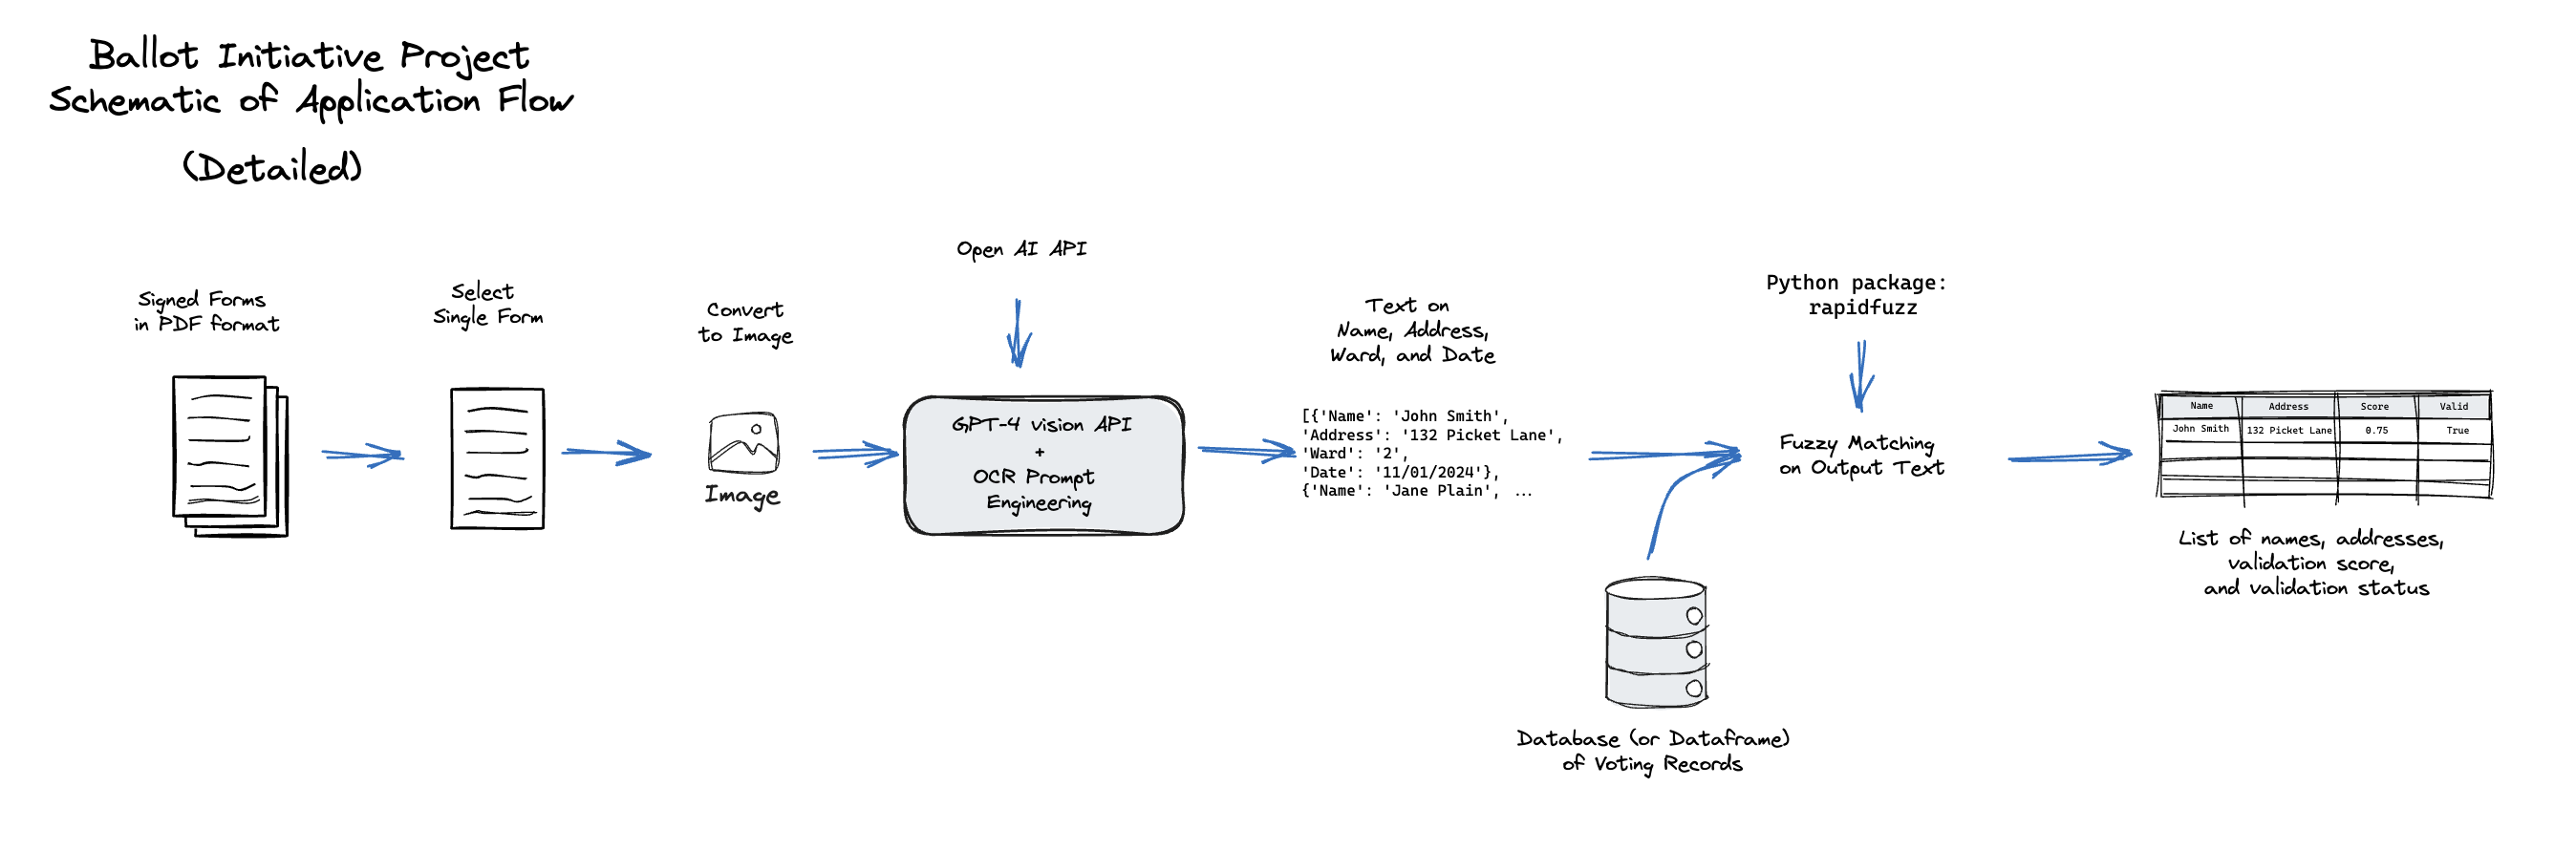

The process of the pipeline
1. An image of a page of signed ballots comes in
2. Perform GPT-based OCR to extract the names from page
3. Compare each name in the extraction to voter record names
4. Output the closest matches for the names (preferably in a table format)

In [ ]:
# full (mini) pipeline

##############
# BALLOT OCR #
##############

# defining single image path
ballot_image = ballot_file_name

# ocr processing of image
ocr_data = extract_signature_info(f"{ballot_image}")

#######################
# VALIDATION/MATCHING #
#######################

# empty list of voter signature data
match_data = list()

# cycling through processed data
for elem in ocr_data:

    # temporary dictionary of results
    tmp_dict = dict()

    # name determined from OCR
    tmp_dict['OCR NAME'] = elem['Name']

    # index and score of closest match name
    idx, score = score_function_fuzz(elem['Name'], full_name_list)[0]

    # matched voter name
    tmp_dict['MATCHED VOTER NAME'] = full_name_list[idx]

    # match score
    tmp_dict['MATCH_SCORE'] = score

    # appending data to dictionary
    match_data.append(tmp_dict)

In [ ]:
# displaying data and matches
pd.DataFrame(match_data)

,OCR NAME,MATCHED VOTER NAME,MATCH_SCORE
0,James Hatch,James Hatch,1.000000
1,Lynn Ly,Lynn Ly,1.000000
2,Bruce Mumia,Bruce Murray,0.782609
3,Molling Liu,Moling Liu,0.952381
4,Alexandra Karabatsos,Alexandra Karabatsos,1.000000


## Post-Onboarding Work

That's the end of the onboarding notebook. If you worked through this, you now know the basic functions that run in the background of the application, and you have all the knowledge you need to start making contributions. Here is a list of tasks you can explore as project contributions following this onboarding.

- **Medium-Size Tasks:** Involving additions to existing code and slightly changing existing structure.
    - **Address Validation:** As shown in the above example, we only consider try to find voter record matchings between names. Ideally, we want to check the close matches for the names and *then* ensure that the associated addresses match what is found in the voter records DB. This is a missing feature of the current code.
    - **Fuzzy Match Scoring:** We chose a pretty quick fuzzmatch method (`ratio`), but there are literally dozens of other methods we could explore. It would be good to understand which is the best one to use and why.
    - Other methods are described here: https://rapidfuzz.github.io/RapidFuzz/Usage/fuzz.html
    - **Streamlit Application Cleanup:** Most of the code as it is depicted in this notebook also exists in the `app.py` file for the streamlit application, but it is not in its most readable and well-documented form. Cleaning up that code and ensuring that it is written efficiently is a desired task.


- **Large Tasks:** Involving extensive rewrites of existing code and creating new structure.
    - **OCR Approach:** Currently our approach to performing OCR on the ballots is incredibly sketchy. We need to effectively lie to GPT in order to get it to process the ballots correctly. This isn't ideal so we would *like* to find alternative OCR approaches that perform as well as GPT. (This has difficult to do since GPT performs so well)

    - **Alternative Data Access Schemes:** This one is mostly ideation and testing. Currently, running the application is tied to the existence of a voter records csv (i.e., `raw_feb_23_city_wide.csv`) that exists locally on the user's laptop. This probably isn't the best approach for storing the voter records, so we would want to explore others. Some possibilities
        - Database Storage: We could store the voter records file in a database that is accessed when we run the program. The problem is that this file is proprietary (although it can be requested), and we would want to limit access.
        - User Upload: We could just require the use to upload their own CSV with properly formatted columns. This would make the application more generally applicable (e.g., anyone with a collection of PDF ballots and a voter records file could use it)
        - Something Else: There might be some other ideas not listed above.     

- **Extra Large Tasks:** Involves extensive code writing and completing changing existing application structure.
    - **More Robust Frontend and Stack:** The application "frontend" is currently generated by `streamlit`. This is good for quick and dirty demonstrations, but we might want something more robust in the future. Here are some possibilities.
        - Django App: Transfer the stack to the django framework (https://www.djangoproject.com/). We could then use HTML/CSS Django templates to build the frontend.
            - We could also use the Django backend but with React JS frontend.

